---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'mlops-cloud-427521'

In [2]:
REGION = 'us-central1'
DATANAME = 'heart'
NOTEBOOK = '02c'

# Resources
DEPLOY_COMPUTE = 'n1-standard-2'

# Model Training
VAR_TARGET = 'HeartDisease'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
!pip install -U google-cloud-pipeline-components -U -q

In [20]:
from google.cloud import aiplatform
from datetime import datetime
import kfp
from kfp import compiler, dsl#import kfp.v2.dsl as dsl
#import google_cloud_pipeline_components as gcc_aip
from google_cloud_pipeline_components.v1.dataset import TabularDatasetCreateOp
from google_cloud_pipeline_components.v1.automl.training_job import AutoMLTabularTrainingJobRunOp
from google_cloud_pipeline_components.v1.endpoint import EndpointCreateOp, ModelDeployOp

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np
from google.cloud import bigquery
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from google.cloud import storage
import joblib

clients:

In [5]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client()
bq

parameters:

In [6]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

In [7]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'361807449633-compute@developer.gserviceaccount.com'

List the service accounts current roles:

In [8]:
!gcloud projects get-iam-policy $PROJECT_ID --filter="bindings.members:$SERVICE_ACCOUNT" --format='table(bindings.role)' --flatten="bindings[].members"

ROLE
roles/editor


>Note: If the resulting list is missing [roles/storage.objectAdmin](https://cloud.google.com/storage/docs/access-control/iam-roles) then [revisit the setup notebook](../00%20-%20Setup/00%20-%20Environment%20Setup.ipynb#permissions) and add this permission to the service account with the provided instructions.

environment:

In [9]:
!rm -rf {DIR}
!mkdir -p {DIR}

import google.cloud.aiplatform as aiplatform
import kfp
from kfp import compiler, dsl
from kfp.dsl import Artifact, Dataset, Input, Metrics, Model, Output, component---
## Pipeline (KFP) Definition
- Flow
    - Create Vertex AI Dataset from link to BigQuery table
    - Create Vertex AI AutoML Tabular Training Job
    - Create Endpoint and Depoy trained model
    
Use [AI Platform Pipeline Components](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/)
- Specifically, [AutoMLTabularTrainingJobRunOp](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.AutoMLTabularTrainingJobRunOp)

Define a Job:
- Consider Weighting
- Model Type
- Optimization Objective

In [14]:
import google.cloud.aiplatform as aiplatform
import kfp
from kfp import compiler, dsl
from kfp.dsl import Artifact, Dataset, Input, Metrics, Model, Output, component

In [ ]:
@component(
    packages_to_install=[
        "xgboost==1.6.2",
        "pandas==1.3.5",
        "joblib==1.1.0",
        "scikit-learn==1.0.2",
        "gcsfs==2022.7.1",  # Añadido para trabajar con GCS
    ],
)
def xgboost_training(
    model: Output[Model],
    metrics: Output[Metrics],
):
    """Trains an XGBoost classifier.

    Args:
        dataset: The training dataset.

    Returns:
        model: The model artifact stores the model.bst file.
        metrics: The metrics of the trained model.
    """
    import os

    import joblib
    import pandas as pd
    import xgboost as xgb
    from sklearn.metrics import (accuracy_score, precision_recall_curve,
                                 roc_auc_score)
    from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                         train_test_split)
    from sklearn.preprocessing import LabelEncoder

    # Load the training census dataset
    df = pd.read_csv("gs://mlops-cloud-427521/heart-failure/heart.csv")

    CATEGORICAL_COLUMNS = (
        "Sex",
        "ChestPainType",
        "RestingECG",
        "ExerciseAngina",
        "ST_Slope"
    )
    LABEL_COLUMN = "HeartDisease"

    # Convert data in categorical columns to numerical values
    encoders = {col: LabelEncoder() for col in CATEGORICAL_COLUMNS}
    for col in CATEGORICAL_COLUMNS:
        df[col] = encoders[col].fit_transform(df[col])

    X = df.drop(LABEL_COLUMN, axis=1)
    y = df[LABEL_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    params = {
        "reg_lambda": [0, 1],
        "gamma": [1, 1.5, 2, 2.5, 3],
        "max_depth": [2, 3, 4, 5, 10, 20],
        "learning_rate": [0.1, 0.01],
    }

    xgb_model = xgb.XGBClassifier(
        n_estimators=50,
        objective="binary:hinge",
        silent=True,
        nthread=1,
        eval_metric="auc",
    )

    folds = 5
    param_comb = 20

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=params,
        n_iter=param_comb,
        scoring="precision",
        n_jobs=4,
        cv=skf.split(X_train, y_train),
        verbose=4,
        random_state=42,
    )

    random_search.fit(X_train, y_train)
    xgb_model_best = random_search.best_estimator_
    predictions = xgb_model_best.predict(X_test)
    score = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)
    _ = precision_recall_curve(y_test, predictions)

    metrics.log_metric("accuracy", (score * 100.0))
    metrics.log_metric("framework", "xgboost")
    metrics.log_metric("dataset_size", len(df))
    metrics.log_metric("AUC", auc)

    # Export the model to a file as .bst
    os.makedirs(model.path, exist_ok=True)
    joblib.dump(rf_model_best, os.path.join(model.path, "model.joblib"))


In [ ]:
@component(
    packages_to_install=[
        "pandas==1.3.5",
        "joblib==1.1.0",
        "scikit-learn==1.0.2",
        "gcsfs==2022.7.1",  # Añadido para trabajar con GCS
    ],
)
def randomforest_training(
    model: Output[Model],
    metrics: Output[Metrics],
):
    """Trains a RandomForest classifier.

    Args:
        dataset: The training dataset.

    Returns:
        model: The model artifact stores the model.joblib file.
        metrics: The metrics of the trained model.
    """
    import os

    import joblib
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import (accuracy_score, precision_recall_curve,
                                 roc_auc_score)
    from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                         train_test_split)
    from sklearn.preprocessing import LabelEncoder

    # Load the training dataset
    df = pd.read_csv("gs://mlops-cloud-427521/heart-failure/heart.csv")

    CATEGORICAL_COLUMNS = (
        "Sex",
        "ChestPainType",
        "RestingECG",
        "ExerciseAngina",
        "ST_Slope"
    )
    LABEL_COLUMN = "HeartDisease"

    # Convert data in categorical columns to numerical values
    encoders = {col: LabelEncoder() for col in CATEGORICAL_COLUMNS}
    for col in CATEGORICAL_COLUMNS:
        df[col] = encoders[col].fit_transform(df[col])

    X = df.drop(LABEL_COLUMN, axis=1)
    y = df[LABEL_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    params = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    }

    rf_model = RandomForestClassifier()

    folds = 5
    param_comb = 20

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        rf_model,
        param_distributions=params,
        n_iter=param_comb,
        scoring="precision",
        n_jobs=4,
        cv=skf.split(X_train, y_train),
        verbose=4,
        random_state=42,
    )

    random_search.fit(X_train, y_train)
    rf_model_best = random_search.best_estimator_
    predictions = rf_model_best.predict(X_test)
    score = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)
    _ = precision_recall_curve(y_test, predictions)

    metrics.log_metric("accuracy", (score * 100.0))
    metrics.log_metric("framework", "randomforest")
    metrics.log_metric("dataset_size", len(df))
    metrics.log_metric("AUC", auc)

    # Export the model to a file
    os.makedirs(model.path, exist_ok=True)
    joblib.dump(rf_model_best, os.path.join(model.path, "model.joblib"))


In [ ]:

@component(
    packages_to_install=["google-cloud-aiplatform==1.25.0"],
)
def deploy_model(
    model: Input[Model],
    project_id: str,
    serving_container_image_uri: str,
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model],
):
    """Deploys an XGBoost model to Vertex AI Endpoint.

    Args:
        model: The model to deploy.
        project_id: The project ID of the Vertex AI Endpoint.

    Returns:
        vertex_endpoint: The deployed Vertex AI Endpoint.
        vertex_model: The deployed Vertex AI Model.
    """
    from google.cloud import aiplatform

    aiplatform.init(project=project_id)

    deployed_model = aiplatform.Model.upload(
        display_name="census-demo-model",
        artifact_uri=model.uri,
        serving_container_image_uri=serving_container_image_uri,
    )
    endpoint = deployed_model.deploy(machine_type="n1-standard-4")

    vertex_endpoint.uri = endpoint.resource_name
    vertex_model.uri = deployed_model.resource_name

In [108]:
@dsl.pipeline(
    name="census-demo-pipeline-randomforest",
)
def pipeline():
    # Paso 2: Tarea de entrenamiento RandomForest
    training_task_randomforest = randomforest_training()
    training_task_xgboost = xgboost_training()
    # Paso 3: Desplegar el modelo en Vertex AI
    deploy_task_xgboost = deploy_model(
        project_id=PROJECT_ID,
        model=training_task_xgboost.outputs["model"],
        serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-6:latest"
    )
    deploy_task_randomforest = deploy_model(
        project_id=PROJECT_ID,
        model=training_task_randomforest.outputs["model"],
        serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest"
    )

In [109]:
compiler.Compiler().compile(pipeline_func=pipeline, package_path="pipeline.yaml")


In [110]:

job = aiplatform.PipelineJob(
    display_name="census-demo-pipeline",
    template_path="pipeline.yaml"
)

job.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/361807449633/locations/us-central1/pipelineJobs/census-demo-pipeline-randomforest-20240711182212
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/361807449633/locations/us-central1/pipelineJobs/census-demo-pipeline-randomforest-20240711182212')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/census-demo-pipeline-randomforest-20240711182212?project=361807449633
PipelineJob projects/361807449633/locations/us-central1/pipelineJobs/census-demo-pipeline-randomforest-20240711182212 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/361807449633/locations/us-central1/pipelineJobs/census-demo-pipeline-randomforest-20240711182212 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/361807449633/locations/us-central1/pipelineJobs/census-demo-pipeline-randomforest-20240711182212 current state:


In [102]:
endpoints = aiplatform.Endpoint.list()

In [103]:
endpoints

 resource name: projects/361807449633/locations/us-central1/endpoints/2716143365304352768,
 resource name: projects/361807449633/locations/us-central1/endpoints/5077155469953335296,
 resource name: projects/361807449633/locations/us-central1/endpoints/2685744067819601920,
 resource name: projects/361807449633/locations/us-central1/endpoints/5721170216667316224,
 resource name: projects/361807449633/locations/us-central1/endpoints/4729252398738964480,
 resource name: projects/361807449633/locations/us-central1/endpoints/8543519808145063936,
 resource name: projects/361807449633/locations/us-central1/endpoints/6633571353674907648,
 resource name: projects/361807449633/locations/us-central1/endpoints/5480649849068060672,
 resource name: projects/361807449633/locations/us-central1/endpoints/868963830640672768,
 resource name: projects/361807449633/locations/us-central1/endpoints/1541126075025719296,
 resource name: projects/361807449633/locations/us-central1/endpoints/1653716065709981696,


In [104]:
for i in range (6):
    endpoints[i].undeploy_all()
    endpoints[i].delete()

Deleting Endpoint : projects/361807449633/locations/us-central1/endpoints/2716143365304352768
Endpoint deleted. . Resource name: projects/361807449633/locations/us-central1/endpoints/2716143365304352768
Deleting Endpoint resource: projects/361807449633/locations/us-central1/endpoints/2716143365304352768
Delete Endpoint backing LRO: projects/361807449633/locations/us-central1/operations/7786405756344991744
Endpoint resource projects/361807449633/locations/us-central1/endpoints/2716143365304352768 deleted.
Deleting Endpoint : projects/361807449633/locations/us-central1/endpoints/5077155469953335296
Endpoint deleted. . Resource name: projects/361807449633/locations/us-central1/endpoints/5077155469953335296
Deleting Endpoint resource: projects/361807449633/locations/us-central1/endpoints/5077155469953335296
Delete Endpoint backing LRO: projects/361807449633/locations/us-central1/operations/1535409473554743296
Endpoint resource projects/361807449633/locations/us-central1/endpoints/507715546

In [84]:
endpoints[0].delete()

Deleting Endpoint : projects/361807449633/locations/us-central1/endpoints/2914301748908654592
Endpoint deleted. . Resource name: projects/361807449633/locations/us-central1/endpoints/2914301748908654592
Deleting Endpoint resource: projects/361807449633/locations/us-central1/endpoints/2914301748908654592
Delete Endpoint backing LRO: projects/361807449633/locations/us-central1/operations/2093855827348684800
Endpoint resource projects/361807449633/locations/us-central1/endpoints/2914301748908654592 deleted.


In [121]:
download_from_gcs_op = components.load_component_from_url("https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/399405402d95f4a011e2d2e967c96f8508ba5688/community-content/pipeline_components/google-cloud/storage/download/component.yaml")
select_columns_using_Pandas_on_CSV_data_op = components.load_component_from_url("https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/399405402d95f4a011e2d2e967c96f8508ba5688/community-content/pipeline_components/pandas/Select_columns/in_CSV_format/component.yaml")
fill_all_missing_values_using_Pandas_on_CSV_data_op = components.load_component_from_url("https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/399405402d95f4a011e2d2e967c96f8508ba5688/community-content/pipeline_components/pandas/Fill_all_missing_values/in_CSV_format/component.yaml")
binarize_column_using_Pandas_on_CSV_data_op = components.load_component_from_url("https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/399405402d95f4a011e2d2e967c96f8508ba5688/community-content/pipeline_components/pandas/Binarize_column/in_CSV_format/component.yaml")
split_rows_into_subsets_op = components.load_component_from_url("https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/399405402d95f4a011e2d2e967c96f8508ba5688/community-content/pipeline_components/dataset_manipulation/Split_rows_into_subsets/in_CSV/component.yaml")
train_XGBoost_model_on_CSV_op = components.load_component_from_url("https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/399405402d95f4a011e2d2e967c96f8508ba5688/community-content/pipeline_components/XGBoost/Train/component.yaml")
xgboost_predict_on_CSV_op = components.load_component_from_url("https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/399405402d95f4a011e2d2e967c96f8508ba5688/community-content/pipeline_components/XGBoost/Predict/component.yaml")
upload_XGBoost_model_to_Google_Cloud_Vertex_AI_op = components.load_component_from_url("https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/399405402d95f4a011e2d2e967c96f8508ba5688/community-content/pipeline_components/google-cloud/Vertex_AI/Models/Upload_XGBoost_model/component.yaml")
deploy_model_to_endpoint_op = components.load_component_from_url("https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/399405402d95f4a011e2d2e967c96f8508ba5688/community-content/pipeline_components/google-cloud/Vertex_AI/Models/Deploy_to_endpoint/component.yaml")

In [102]:
model_resource_name = aiplatform.Model.list(filter=f'display_name="{model_namea}"')[0].resource_name


---
## Compile Pipeline

In [106]:
compiler.Compiler().compile(
    pipeline_func = pipeline,
    package_path = f"{DIR}/{NOTEBOOK}.json"
)

Move compiled pipeline files to GCS Bucket

In [107]:
!gsutil cp {DIR}/{NOTEBOOK}.json {URI}/{TIMESTAMP}/kfp/

Copying file://temp/02c/02c.json [Content-Type=application/json]...
/ [1 files][ 54.8 KiB/ 54.8 KiB]                                                
Operation completed over 1 objects/54.8 KiB.                                     


---
## Create Vertex AI Pipeline Job

Get features dictionary for the pipeline input:

Run The pipeline:

Visual Representation of the pipeline can be viewed in the colsole:

In [22]:
print(f"Review the Pipeline as it runs here:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/pipelines/runs/{pipeline.resource_name.split('/')[-1]}?project={PROJECT_ID}")

Review the Pipeline as it runs here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-02c-heart-20240626000834-20240626021255?project=mlops-cloud-427521


Retrieve the pipeline information:

---
## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.

<p align="center" width="100%"><center><a href="https://youtu.be/m_x3WBtr6y0" target="_blank" rel="noopener noreferrer"><img src="../architectures/thumbnails/playbutton/02c.png" width="40%"></a></center></p>
<p align="center" width="100%"><center>Part 2 Video</center></p>

Notes Since Video:
- update notebook on 8/31/2022 to:
    - make the pipeline run with input parameters rather than using local variable in the pipeline definition
    - update the model evaluation section to show update Python Client methods for metric retrieval

For more information review [this page](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models).

Get the Model:

In [114]:
models = aiplatform.Model.list(filter=f'labels.notebook={NOTEBOOK}')

In [115]:
model = models[0]
model.resource_name

'projects/361807449633/locations/us-central1/models/2108292655539552256'

Retrives the aggregate model evalution metrics for the model as a whole.  

Either:
- First, use `model.list_model_evaluations()` to retrieve the evaluation id, then use `model.get_model_evaluation(evaluation_id = )` for the evaluation id
- Or, use `.get_model_evaluation()` and it will retrieve the first model evaluation

In [116]:
evaluation = model.get_model_evaluation().to_dict() # get first evaluation

In [136]:
evaluation.keys()

dict_keys(['name', 'metricsSchemaUri', 'metrics', 'createTime', 'sliceDimensions', 'modelExplanation'])

In [36]:
evaluation['metrics'].keys()

dict_keys(['confusionMatrix', 'confidenceMetrics', 'auPrc', 'auRoc', 'logLoss'])

In [137]:
evaluation['metrics']['auPrc']

0.99590755

In [138]:
evaluation['metrics']['confidenceMetrics'][3]

{'precisionAt1': 0.98203593,
 'falsePositiveCount': '115',
 'trueNegativeCount': '52',
 'f1ScoreMicro': 0.7438753,
 'confusionMatrix': {'rows': [[82.0, 1.0, 0.0],
   [2.0, 82.0, 0.0],
   [0.0, 0.0, 0.0]],
  'annotationSpecs': [{'id': '0', 'displayName': '1'},
   {'id': '1', 'displayName': '0'},
   {'id': 'DROPPED', 'displayName': 'DROPPED'}]},
 'falsePositiveRate': 0.6886228,
 'falsePositiveRateAt1': 0.017964073,
 'f1ScoreAt1': 0.98203593,
 'confidenceThreshold': 0.01,
 'recallAt1': 0.98203593,
 'f1ScoreMacro': 0.74388885,
 'truePositiveCount': '167',
 'f1Score': 0.7438753,
 'precision': 0.5921986,
 'recall': 1.0}

Review several of the metrics included in the evaluation.  Also, compare these to the results in the console view.

In [139]:
print(f"Review this model in the console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}/versions/{model.version_id}/evaluations/{evaluation['name'].split('/')[-1]}?project={PROJECT_ID}")

Review this model in the console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/5660542046000119808/versions/1/evaluations/6268549179005485699?project=mlops-cloud-427521


In [140]:
evaluation['metrics']['auPrc']

0.99590755

In [141]:
for i in range(len(evaluation['metrics']['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', evaluation['metrics']['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', evaluation['metrics']['confusionMatrix']['rows'][i])

True Label =  1  has Predicted labels =  [82.0, 1.0, 0.0]
True Label =  0  has Predicted labels =  [2.0, 82.0, 0.0]
True Label =  DROPPED  has Predicted labels =  [0.0, 0.0, 0.0]


For models with labels you can retrieve the evaluation metrics for each slice of the model as well using the .gapic api version:

In [142]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

In [143]:
slices = model_client.list_model_evaluation_slices(parent = evaluation['name'])

In [144]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  0 has auPrc =  0.9958107
Label =  1 has auPrc =  0.9955564


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [145]:
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, splits, {VAR_OMIT})
        FROM {DATANAME}.{DATANAME}_prepped
        WHERE splits='TEST'
        LIMIT 10
    """
).to_dataframe()

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [146]:
pred.head(4)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,61,M,NAP,200,0,1,ST,70,False,0.0,Flat
1,62,M,ASY,115,0,1,Normal,72,True,-0.5,Flat
2,55,M,ASY,172,260,0,Normal,73,False,2.0,Flat
3,52,M,ASY,160,246,0,ST,82,True,4.0,Flat


In [147]:
pred['Age'] = pred['Age'].astype(str)
pred['RestingBP'] = pred['RestingBP'].astype(str)
pred['Cholesterol'] = pred['Cholesterol'].astype(str)
pred['FastingBS'] = pred['FastingBS'].astype(str)
pred['MaxHR'] = pred['MaxHR'].astype(str)
pred['Oldpeak'] = pred['Oldpeak'].astype(float)
newobs = pred.to_dict(orient='records')
newobs[0]

{'Age': '61',
 'Sex': 'M',
 'ChestPainType': 'NAP',
 'RestingBP': '200',
 'Cholesterol': '0',
 'FastingBS': '1',
 'RestingECG': 'ST',
 'MaxHR': '70',
 'ExerciseAngina': False,
 'Oldpeak': 0.0,
 'ST_Slope': 'Flat'}

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [148]:
instances = [json_format.ParseDict(newob, Value()) for newob in newobs]

### Get Predictions: Python Client

In [149]:
aiplatform.Endpoint.list(filter=f'labels.notebook={NOTEBOOK}')

 resource name: projects/361807449633/locations/us-central1/endpoints/5194424982125412352,
 resource name: projects/361807449633/locations/us-central1/endpoints/6262903993719062528]

In [150]:
endpoint = aiplatform.Endpoint.list(filter=f'labels.notebook={NOTEBOOK}')[0]
endpoint.display_name

'02c_heart_20240626000834'

In [151]:
prediction = endpoint.predict(instances = instances) # or instances = newobs
prediction.predictions[0]

{'classes': ['1', '0'], 'scores': [0.9910398125648499, 0.008960234932601452]}

In [152]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'1'

### Get Predictions: REST

In [153]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newobs[0]]}))

In [154]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "classes": [
        "1",
        "0"
      ],
      "scores": [
        0.99103981256484985,
        0.0089602349326014519
      ]
    }
  ],
  "deployedModelId": "513376272659775488",
  "model": "projects/361807449633/locations/us-central1/models/5660542046000119808",
  "modelDisplayName": "02c_heart_20240626000834",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [155]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['1', '0'], 'scores': [0.9910398125648499, 0.008960234932601452]}]


---
## Explanations
Interpretation Guide
- https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [156]:
explanation = endpoint.explain(instances = instances)

In [157]:
explanation.predictions[0]

{'classes': ['1', '0'], 'scores': [0.9910398125648499, 0.008960234932601452]}

In [158]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.8618397116661072
instance output 0.9910398125648499
output_index [0]
output display value 1
approximation error 0.004171536581263382


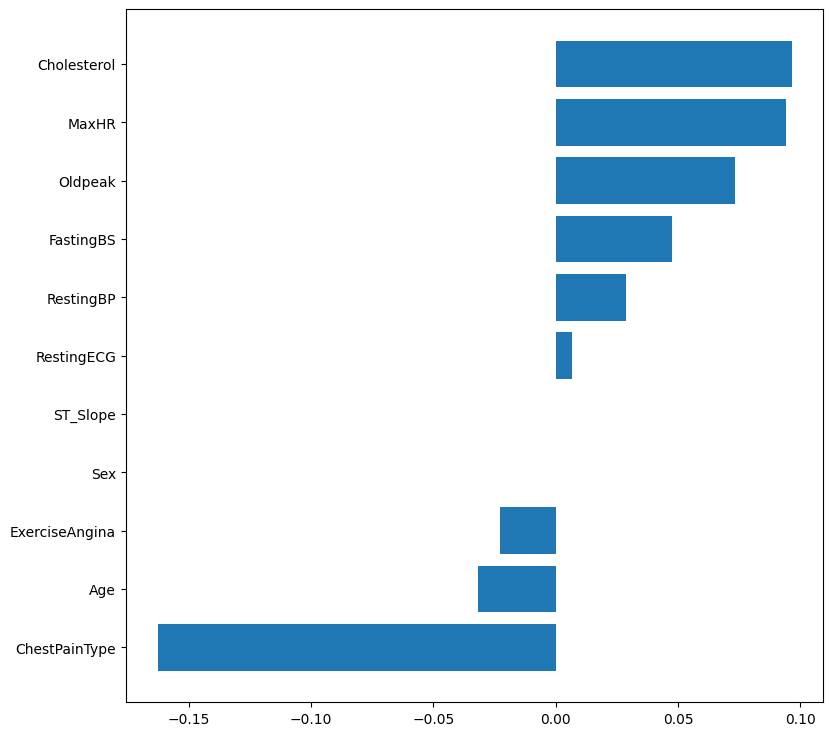

In [159]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations

In [ ]:
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    model_name = endpoint.list_models()[0].model,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation=True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/361807449633/locations/us-central1/batchPredictionJobs/5080101233402839040
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/361807449633/locations/us-central1/batchPredictionJobs/5080101233402839040')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/5080101233402839040?project=361807449633
BatchPredictionJob projects/361807449633/locations/us-central1/batchPredictionJobs/5080101233402839040 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/361807449633/locations/us-central1/batchPredictionJobs/5080101233402839040 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/361807449633/locations/us-central1/batchPredictionJobs/5080101233402839040 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/361807449633/locations/us-central1/batchPredictionJobs/

---
## Remove Resources
see notebook "99 - Cleanup"